In [700]:
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
import helper
from time import sleep
import numpy as np

## Load Data

- Created a batch of 32 for each train and test set
- 0 is Rose
- 1 is Sunflower

In [701]:
data_dir = '/home/rohit/Desktop/flowers'
# batch size
# Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(10),
                                       transforms.Resize((255, 255)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                      ])

test_transforms = transforms.Compose([transforms.Resize((255, 255)),
                                     transforms.ToTensor()])


# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=300, shuffle = True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=90)

## Iterate through all images in batch
1. Train batch by batch
2. FLatten images
3. Intializing weights and biases to zeros
4. Transfer to GPU

In [702]:
def dataload(loader,m):    
    data_iter = iter(loader)
    images, labels = next(data_iter)
    print('initial image size = ', images.shape)
    images = images.reshape(m,-1).t() /255
    print('flattened image size = ', images.shape)
    (nx,m) = images.shape # m is no of training exmples 
    return images,labels,nx,m

In [703]:
images,labels,nx,m = dataload(trainloader,300)
X = images # (nx x m)
Y = labels 
Y = torch.reshape(Y,(1,300)) # (1 x m)
Y = Y.float()

initial image size =  torch.Size([300, 3, 255, 255])
flattened image size =  torch.Size([195075, 300])


In [704]:
w = torch.randn((nx,1)) #weights
b = torch.randn(1)#biases

In [705]:
images,labels,nx,n = dataload(testloader,90)
X_test = images # (nx x m)
Y_test = labels 
Y_test = torch.reshape(Y_test,(1,n)) # (1 x m)
Y_test = Y_test.float()

initial image size =  torch.Size([90, 3, 255, 255])
flattened image size =  torch.Size([195075, 90])


### Helper functions





$sigmoid( w^T x + b) = \frac{1}{1 + e^{-(w^T x + b)}}$

In [706]:
m = 300
def sigmoid(x):
    return (1 / (1+torch.exp(-x)))

Forward Propagation:
- Get X
- Compute $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- Calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Formulas:

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [707]:
def parameters(w, b, X, Y):
    A = sigmoid(torch.mm(w.t(), X)+b) # dimension (1 x m)
    cost = -(torch.mm(Y , torch.log(A.t())) + torch.mm((1-Y) , torch.log( (1-A).t() ) )) / m
    dz = A - Y
    db = (torch.sum(dz))  /  m
    dw = torch.mm(X, dz.t())
    
    assert(dw.shape == w.shape)
    
    return cost,dw,db

In [708]:
def predict(w,b,X):
    A = sigmoid(torch.mm(w.t(), X)+b)
    
    Y_prediction = torch.zeros((1,X.shape[1]))
    for i in range(X.shape[1]):
        
        if A[0,i] > 0.5:
            Y_prediction[0,i] = 1
        else:
            Y_prediction[0,i] = 0
            
    return Y_prediction

In [709]:
parameters(w, b, X, Y)

(tensor([[1.0229]]), tensor([[-0.0039],
         [-0.0131],
         [-0.0250],
         ...,
         [-0.0090],
         [-0.0041],
         [-0.0012]]), tensor(-0.3255))

In [710]:
def optimize(w, b, X, X_test, Y, num_iterations, alpha):
    
    cost_arr = []
    Y_p_train = []
    Y_p_test = []
    for i in range(num_iterations):
        
        cost,dw,db = parameters(w, b, X, Y)
        w = w - alpha * dw
        b = b - alpha * db
        
        if num_iterations % 1000 == 0:
            cost_arr.append(cost)
            
            Y_prediction_train = predict(w, b, X)
            t1 = 100 - torch.mean(torch.abs(Y_prediction_train - Y)) * 100
            Y_p_train.append(t1)
            
            Y_prediction_test = predict(w, b, X_test)
            t2 = 100 - torch.mean(torch.abs(Y_prediction_test - Y_test)) * 100
            Y_p_test.append(t2)
            # print("test accuracy: ", t2, "train accuracy: ",t1)
    
    return cost_arr, w, b, Y_p_train, Y_p_test


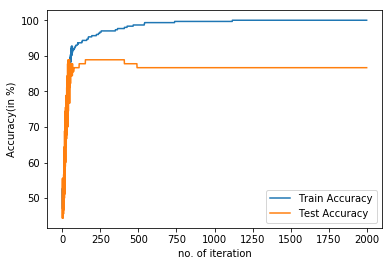

In [711]:
cost_arr, w, b, Y_p_train, Y_p_test = optimize(w, b, X, X_test, Y, 2000, 0.1)
plt.ylabel('Accuracy(in %)')
plt.xlabel('no. of iteration')
plt.plot(Y_p_train, label = 'Train Accuracy')
plt.plot(Y_p_test, label ='Test Accuracy')
plt.legend()

In [714]:
Y_p_train[-1]

tensor(100.)

In [724]:
Y_p_test[-1]

tensor(86.6667)